# Data quality check

Pull a trading pair data and examine it.

In [4]:
from tradingstrategy.chain import ChainId
import datetime
from tradeexecutor.strategy.reserve_currency import ReserveCurrency
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradingstrategy.client import Client
from tradeexecutor.strategy.trading_strategy_universe import load_pair_data_for_single_exchange, TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions

#
# Strategy properties
#

STRATEGY_NAME = "ETH 15m grid search Polygon 8"

# How often the strategy performs the decide_trades cycle.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_15m

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.m15

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.m5

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Which trading pair we are backtesting on
# (Might be different from the live trading pair)
# https://tradingstrategy.ai/trading-view/polygon/quickswap/eth-usdc
TRADING_PAIR = (ChainId.polygon, "uniswap-v3", "WETH", "USDC", 0.0005)

# How much % of the cash to put on a single trade
POSITION_SIZE = 0.50

# Start with this amount of USD
INITIAL_DEPOSIT = 5_000

#
# Strategy inputs
#

# How many candles we load in the decide_trades() function for calculating indicators
LOOKBACK_WINDOW = 150

# How many candles we use to calculate the Relative Strength Indicator
RSI_LENGTH = 14

#
# Grid searched parameters
#_loss

# Bollinger band's standard deviation options
#
# STDDEV = [1.0, 1.5, 1.7, 2.0, 2.5, 2.8]
STDDEV = [0.1, 0.3, 0.6, 1.0]

# RSI must be above this value to open a new position.
RSI_THRESHOLD = [60, 67.5, 70, 72.5, 75]

# What's the moving average length in candles for Bollinger bands
# MOVING_AVERAGE_LENGTH = [15, 20, 25, 30, 35]
MOVING_AVERAGE_LENGTH = [85, 95, 105, 115, 120]

# Backtest range
#
# Note that for this example notebook we deliberately choose a very short period,
# as the backtest completes faster, charts are more readable
# and tables shorter for the demostration.
#
START_AT = datetime.datetime(2022, 9, 1)

# Backtest range
END_AT = datetime.datetime(2023, 4, 1)

# Stop loss relative to the mid price during the time when the position is opened
#
# If the price drops below this level, trigger a stop loss
STOP_LOSS_PCT = 0.98

# What is the trailing stop loss level
TRAILING_STOP_LOSS_PCT = 0.9975

# Activate trailing stop loss when this level is reached
TRAILING_STOP_LOSS_ACTIVATION_LEVEL=1.03

client = Client.create_jupyter_client()

def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:

    # Fetch backtesting datasets from the server
    dataset = load_pair_data_for_single_exchange(
        client,
        time_bucket=CANDLE_TIME_BUCKET,
        pair_tickers=[TRADING_PAIR],
        execution_context=execution_context,
        universe_options=universe_options,
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
        start_time=START_AT,
        end_time=END_AT,
    )

    # Convert loaded data to a trading pair universe
    universe = TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        pair=TRADING_PAIR,
    )

    return universe

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions()
)

pair = universe.get_single_pair()
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles for pair #{pair.internal_id} {pair.get_ticker()}")
print(f"Data ran    ge is {universe.universe.candles.get_timestamp_range()}")

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy
We loaded 25,696 candles for pair #2854973 WETH-USDC
Data ran    ge is (Timestamp('2021-12-21 19:00:00'), Timestamp('2023-04-01 00:00:00'))


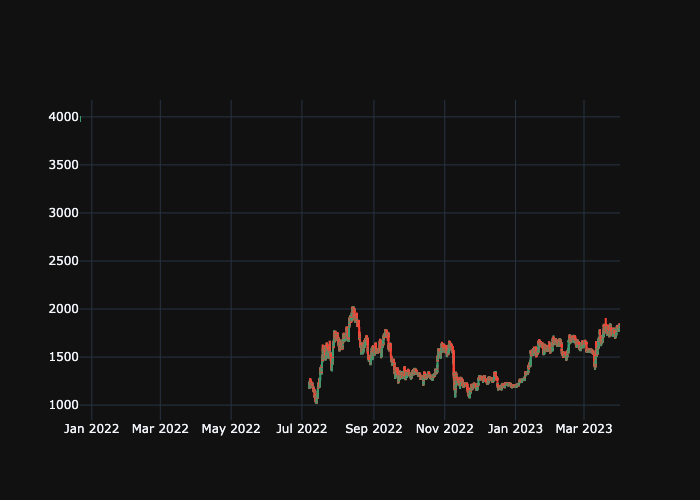

In [5]:
import plotly.graph_objects as go

candles = universe.universe.candles.get_samples_by_pair(pair.internal_id)

fig = go.Figure(
    data=go.Candlestick(x=candles.index, open=candles['open'], high=candles['high'], low=candles['low'], close=candles['close']),
    layout={"xaxis_rangeslider_visible": False}
)
fig.show(renderer="png")

In [6]:
candles

,timestamp,open,high,low,close,exchange_rate,buys,sells,buy_volume,sell_volume,pair_id,start_block,end_block,avg,volume
timestamp,,,,,,,,,,,,,,,
2021-12-21 19:00:00,2021-12-21 19:00:00,3975.032732,4008.962812,3945.727518,3986.576480,1.0,NaN,NaN,NaN,NaN,2854973,22799873,22799958,NaN,NaN
2021-12-21 20:00:00,2021-12-21 20:00:00,4002.954176,4002.954176,4002.954176,4002.954176,1.0,NaN,NaN,NaN,NaN,2854973,22801554,22801554,NaN,NaN
2022-07-07 08:45:00,2022-07-07 08:45:00,1184.941609,1185.652752,1181.510428,1185.534199,1.0,NaN,NaN,NaN,NaN,2854973,30437002,30437151,NaN,NaN
2022-07-07 09:00:00,2022-07-07 09:00:00,1185.534199,1186.482958,1181.510428,1183.875695,1.0,NaN,NaN,NaN,NaN,2854973,30437153,30437564,NaN,NaN
2022-07-07 09:15:00,2022-07-07 09:15:00,1183.875695,1184.230893,1182.337733,1182.337733,1.0,NaN,NaN,NaN,NaN,2854973,30437594,30437961,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 23:00:00,2023-03-31 23:00:00,1826.993738,1826.993738,1826.445749,1826.445749,1.0,NaN,NaN,NaN,NaN,2854973,40995725,40996136,NaN,NaN
2023-03-31 23:15:00,2023-03-31 23:15:00,1826.445749,1826.445749,1824.620308,1825.532800,1.0,NaN,NaN,NaN,NaN,2854973,40996155,40996556,NaN,NaN
2023-03-31 23:30:00,2023-03-31 23:30:00,1825.532800,1825.532800,1823.708271,1823.708271,1.0,NaN,NaN,NaN,NaN,2854973,40996566,40996961,NaN,NaN
